### Newsvendor problem

We've seen how to solve the following formulation of the Newsvendor problem
$$\min_x\ cx +\ \mathbb{E}[Q(x, \xi)]$$
By transforming it into it's deterministic equivalent
$$
  \begin{aligned}
    \min_{x,y,w} & \quad cx + \sum_s p(s)(-ky - rw)\\
    \textrm{s.t.} \quad & y_s \leq w_s\\
     & y_s + w_s \leq x
  \end{aligned}
$$

where $c, k, r$ are the cost, selling price and return price respectively, $p(s)$ is the probability of the $s-th$ demand and $y$ and $w$ are the number of units sold and returned respectively.

Now we're interested in using a risk measure instead of the expected value. The risk measure we'll use is a convex combination of the expected value and the CV@R. Where $\lambda$ is our risk appetite parameter.

$$\min_x\ cx +\ \rho[Q(x, \xi)] = \min_x\ cx +\ \lambda \mathbb{E}[Q(x, \xi)] + (1-\lambda)CV@R[Q(x,\xi)]$$

We know how to handle the expected value as shown above, but how do we handle the CV@R? In order to do so, we must consider the minimization formulation of the CV@R and then incorporate it in the deterministic equivalent.

$$ 
\begin{aligned}
CV@R = \min_{L}\ L + \frac{\mathbb{E}[Q(x,\xi) - L]^+}{1-\alpha}
\end{aligned}
$$

Linearizing the positive function inside the expected value, we get:

$$
  \begin{aligned}
  \min_{L, \theta} &\quad L + \frac{\sum_s p(s)\theta}{1-\alpha}\\
  \textrm{s.t.} \quad & \theta \geq 0\\
    & \theta \geq Q(x,\xi) - L
  \end{aligned}
$$

Now in order to incorporate this in the deterministic equivalent, we must get rid of the $Q(x, \xi)$ on the constraint. We do this by using a "trick" that involves finding a single solution to the second-stage problem for each scenario that is smaller than $\theta$, this works because we're trying make $\theta$ greater than a minimization problem, so any solution that is smaller than $\theta$ will make $\theta$ greater than the actual minimum.

$$
  \begin{aligned}
  \min_{L, \theta} &\quad L + \frac{\sum_s p(s)\theta}{1-\alpha}\\
  \textrm{s.t.} \quad & \theta \geq 0\\
    & \theta_s \geq -ky_s - qw_s - L
  \end{aligned}
$$

Now we can incorporate this in the deterministic equivalent:

$$
  \begin{aligned}
    \min_{x,y_s,w_s,\theta_s, L} & \quad cx + (\lambda)\sum_s p(s)(-sy - rw) + (1-\lambda)(\frac{\sum_s p(s)\theta_s}{1-\alpha} + L)\\
    \textrm{s.t.} \quad & y_s \leq w_s\\
     & y_s + w_s \leq x\\
     & \theta_s \geq 0\\
    & \theta_s \geq -ky_s - qw_s - L
  \end{aligned}
$$

p.s: all computations will use $\alpha$ = 0.9


In [2]:
using JuMP, Plots, HiGHS, PlotlyJS, LinearAlgebra
plotlyjs()
d = collect(50:150)
N = length(d)
p = (1/N)*ones(N)

function Q(x,d)
    m = Model(HiGHS.Optimizer)
    set_silent(m)
    @variables(m, 
    begin
        y ≥ 0
        w ≥ 0
    end)

    @constraints(m,
    begin
        y ≤ d
        y + w ≤ x
    end)

    @objective(m, Min, -25 * y - 5 * w)
    optimize!(m)
    return objective_value(m)
end

g(x) = sum(p[s]*Q(x,d[s]) for s = 1:N)

f(x) = 10*x + g(x)

f (generic function with 1 method)

In [3]:
α = 0.90
λ = 1.0

1.0

In [4]:
function ConvexCombinationDEP(λ)
    
    m = Model(HiGHS.Optimizer)
    set_silent(m)
    
    @variables(m,
    begin
        0 ≤ x ≤ 150
        y[1:N] ≥ 0
        w[1:N] ≥ 0
        l
        θ[1:N] ≥ 0
    end)
    
    @constraints(m,
    begin
        ct1[s=1:N], y[s] ≤ d[s]
        ct2[s=1:N], y[s] + w[s] ≤ x
        ct3[s=1:N], θ[s] ≥ -25*y[s] - 5*w[s] - l
        ct4[s=1:N], θ[s] ≥ 0
    end)
    
    @objective(m, Min, 10 * x + λ*sum(p[s]*(-25*y[s] -5*w[s]) for s = 1:N) + (1-λ)*(l + sum(p[s]*θ[s]/(1-α) for s = 1:N)))
    
    optimize!(m)

    return objective_value(m), value(x)
end


ConvexCombinationDEP (generic function with 1 method)

In [8]:
@show ConvexCombinationDEP(1)
@show ConvexCombinationDEP(0.5)
@show ConvexCombinationDEP(0)

## Solving for the optimal value of newspapers to buy with three different risk appetite levels.

ConvexCombinationDEP(1) = (-1310.6435643564353, 125.0)
ConvexCombinationDEP(0.5) = (-919.3069306930685, 100.0)
ConvexCombinationDEP(0) = (-799.5544554455446, 57.0)


(-799.5544554455446, 57.0)

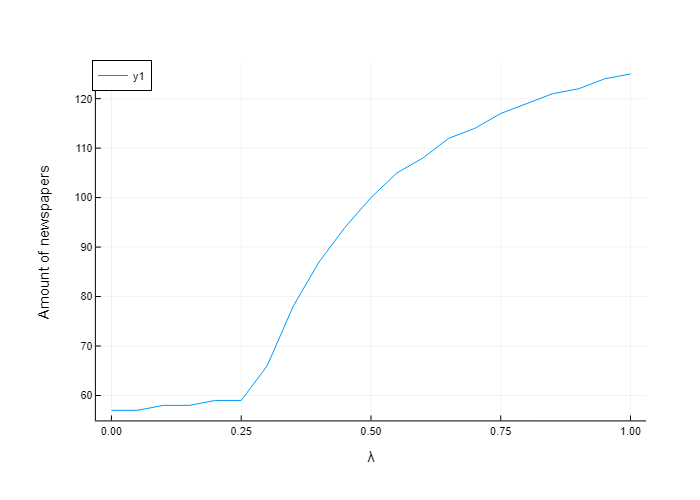

In [6]:
xs = collect(0.00:0.05:1.0)
ys = zeros(length(xs))
for i = 1:length(xs)
    ys[i] = ConvexCombinationDEP(xs[i])[2]
end

Plots.plot(xs, ys, xlabel = "λ", ylabel = "Amount of newspapers", legend = :topleft)

Above we can see that at a certain point, being more conservative results in diminishing returns.

### Benders cut on Newsvendor problem with CV@R dual formulation

In [9]:
function Q_aux(x, d)
    m = Model(HiGHS.Optimizer)
    set_silent(m)
    @variables(m, 
    begin
        y ≥ 0
        w ≥ 0
        x̃
    end)

    @constraints(m,
    begin
        con, x̃ == x
        y ≤ d
        y + w ≤ x̃
    end)

    @objective(m, Min, -25 * y - 5 * w)
    optimize!(m)
    return objective_value(m), shadow_price(con)
end

function dual_cvar(x)
    model = Model(HiGHS.Optimizer)
    set_silent(model)
    @variable(model, q[1:N] >= 0)
    @constraint(model, con1, sum(q) == 1)
    @constraint(model, con2[s=1:N], q[s] ≤ p[s]/(1-α))
    @constraint(model, con3[s=1:N], q[s] ≥ 0)
    @objective(model, Max, sum(q[s]*Q_aux(x, d[s])[1] for s = 1:N))
    optimize!(model)
    return value.(q)
end

function compute_cut(x̂)
    x̂ = value(x)
    Q̄ = zeros(N)
    π̄ = zeros(N)
    for s = 1:N
        Q̄[s] = Q_aux(x̂, d[s])[1]
        π̄[s]= Q_aux(x̂, d[s])[2]
    end
    weights = dual_cvar(x̂)
    Q̄ = Q̄ ⋅ weights
    π̄ = π̄ ⋅ weights
    return (x -> Q̄ + π̄ * (x - x̂))
end

compute_cut (generic function with 1 method)

In [10]:
Q̲ = -6000
# Define master problem
master = Model(HiGHS.Optimizer)
set_silent(master)
@variables(master, begin
    0 <= x <= 200
    θ ≥ Q̲
end)
@objective(master, Min, 10*x + θ)
optimize!(master)

LB = objective_value(master)
x̂ = value(x)
UB = f(x̂)
bestUB = UB

while (bestUB-LB) > 0.1
    l = compute_cut(x̂)
    @constraint(master, θ ≥ l(x))
    optimize!(master)
    LB = objective_value(master)
    x̂ = value(x)
    UB = f(x̂)
    bestUB = min(bestUB, UB)
    GAP = (bestUB-LB)
    @show x̂, bestUB, LB, GAP
end

value(x)

(x̂, bestUB, LB, GAP) = (200.0, -1000.0, -3000.000000000001, 2000.000000000001)


(x̂, bestUB, LB, GAP) = (54.55445544554457, -1000.0, -818.3168316831689, -181.68316831683114)


54.55445544554457

Since we're using Benders for the newsvendor that uses only CV@R in the objective, we should get an approximate result to the risk-averse deterministic equivalent. We can see that the result is very close to the deterministic equivalent (Benders = 54.5 and DEP = 57).